In [1]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics.cluster import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
# Load the dataset
X_train = pd.read_csv("preprocessing_data.csv")
df = pd.read_csv("umist_cropped.csv")

In [3]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [4]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.99) + 1

rnd_pca = PCA(n_components=d, svd_solver='randomized', random_state=123)

X_train_rpca = rnd_pca.fit_transform(X_train)

In [5]:
from sklearn import metrics
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

In [6]:
metrics_list = ['euclidean', 'minkowski', 'cosine', 'cityblock']      

In [7]:
max_clusters = 30  # Maximum number of clusters to test
results = {}
square_distances_matrix = []
clusters_res = []

Average linkage and euclidean metric: 

Number of clusters: 20
Silhouette Score: 0.2650012809154431


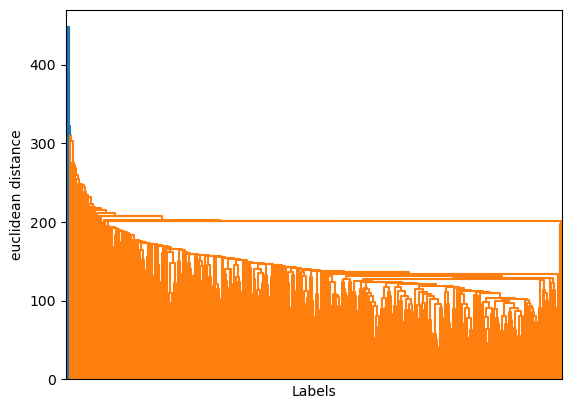

Average linkage and minkowski metric: 

Number of clusters: 20
Silhouette Score: 0.24884912173766335


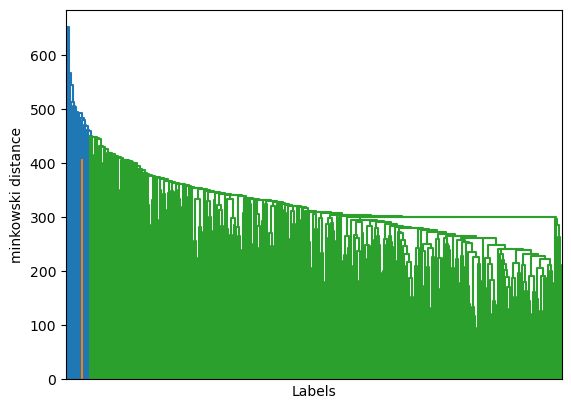

Average linkage and cosine metric: 

Number of clusters: 20
Silhouette Score: 0.09748252588234134


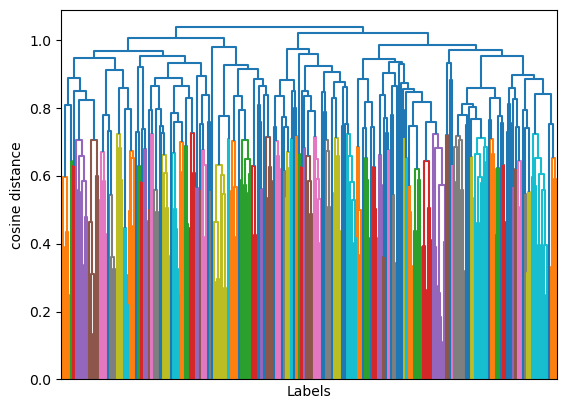

Average linkage and cityblock metric: 

Number of clusters: 20
Silhouette Score: 0.13154860527719595


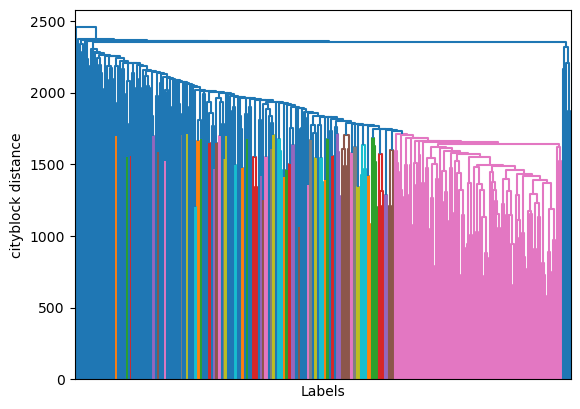

In [8]:
for m in metrics_list:
    print(f'Average linkage and {m} metric: \n')
    if m == 'minkowski':
        Y = pdist(X_train_rpca, metric=m, p=1.5)
    else:
        Y = pdist(X_train_rpca, metric=m)
        
    dist_matrix = squareform(Y)
        
    Z = linkage(Y, method='average')
    clusters = fcluster(Z, 20, criterion='maxclust')
    dendrogram(Z, no_labels= True)
    # Check the number of clusters
    num_clusters = len(set(clusters))
    square_distances_matrix.append(dist_matrix)
    clusters_res.append(clusters)
    print(f'Number of clusters: {num_clusters}')
    silhouette = metrics.silhouette_score(X_train, clusters, metric=m)
    print(f'Silhouette Score: {silhouette}')
    plt.xlabel("Labels")
    plt.ylabel(f'{m} distance')
    plt.show()

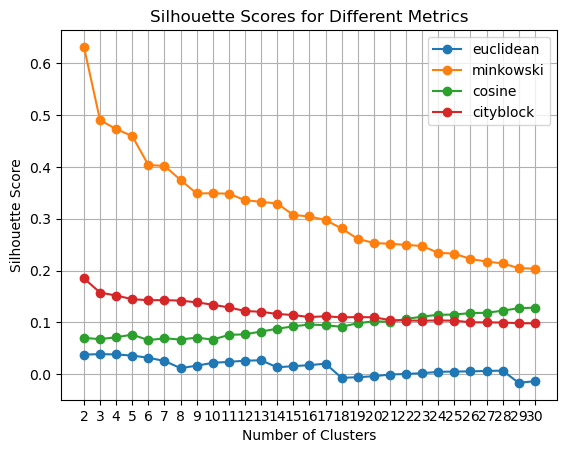

In [9]:
for metric in metrics_list:
    silhouette_scores = []
    
    # Iterate through the possible number of clusters
    for n_clusters in range(2, max_clusters + 1):  # Start from 2 clusters
        # Compute pairwise distances
        if metric == 'minkowski':
            Y = pdist(X_train_rpca, metric=metric, p=1.5)
        else:
            Y = pdist(X_train_rpca, metric=metric)
        
        
        if metric in ['euclidean']:
            Z = linkage(Y, method='ward')
        else:
            Z = linkage(Y, method='average')

        # Create flat clusters
        clusters = fcluster(Z, n_clusters, criterion='maxclust')

        # Check the number of clusters formed
        num_clusters_formed = len(set(clusters))
        
        # Ensure that the number of clusters is valid
        if num_clusters_formed > 1:
            # Calculate silhouette score
            silhouette = metrics.silhouette_score(X_train_rpca, clusters, metric=metric)
            silhouette_scores.append(silhouette)
        else:
            silhouette_scores.append(-1)  # Append a negative score or None if not valid

    # Store results for the current metric
    results[metric] = silhouette_scores

    # Plotting
    plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o', label=metric)

# Plotting
plt.title("Silhouette Scores for Different Metrics")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.xticks(range(2, max_clusters + 1))
plt.legend()
plt.grid()
plt.show()

In [10]:
# Print optimal cluster numbers
for metric, scores in results.items():
    optimal_clusters = np.argmax(scores) + 2  # +2 because we start from 2 clusters
    max_score = scores[optimal_clusters - 2] if optimal_clusters - 2 >= 0 else -1
    if max_score > 0:
        print(f"Optimal number of clusters for {metric}: {optimal_clusters} with a silhouette score of {max_score:.3f}")
    else:
        print(f"Optimal number of clusters for {metric}: No valid clusters formed")

Optimal number of clusters for euclidean: 3 with a silhouette score of 0.039
Optimal number of clusters for minkowski: 2 with a silhouette score of 0.632
Optimal number of clusters for cosine: 30 with a silhouette score of 0.128
Optimal number of clusters for cityblock: 2 with a silhouette score of 0.185


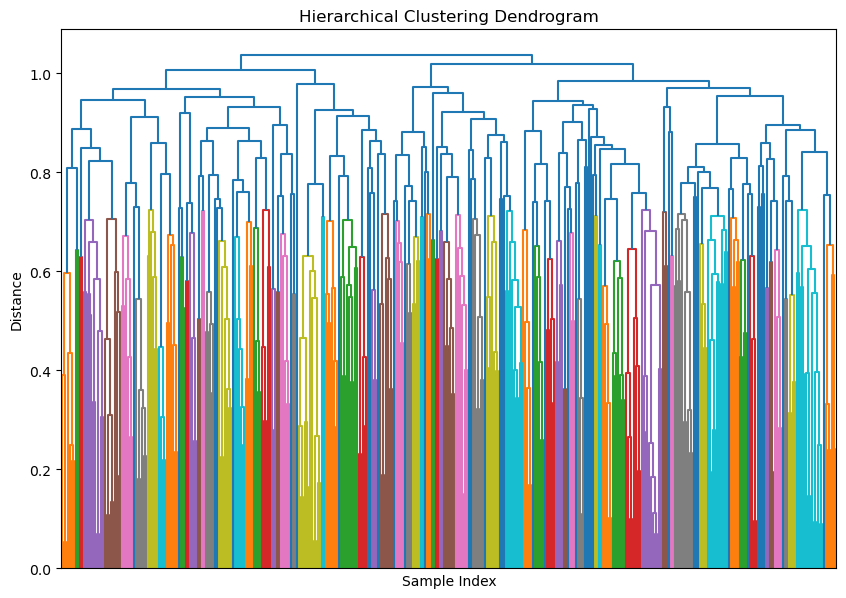

In [11]:
Y = pdist(X_train_rpca, metric='cosine')
        
# Perform hierarchical clustering using linkage
Z = linkage(Y, method='average')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z, no_labels= True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

In [12]:
from scipy.cluster.hierarchy import fcluster

# Set a cutoff distance
cutoff_distance = 20  # Adjust this based on the dendrogram

# Get cluster labels
cluster_labels = fcluster(Z , cutoff_distance, criterion='maxclust')

# Print or analyze the clusters
print("Cluster labels for each image:", cluster_labels)

print(np.unique(cluster_labels))

Cluster labels for each image: [13 13 13  2  2  2 13 13  1 13 13 13 13  2 13  2 13  1  2 13  4 13 20 20
  4 20 13  4  4 13  4 13 20 20 13  4  4  8 20 20 19 19  4  4 19 19 19  4
 19 19 19 19 19  4 19 19  4  4 19 19 15 15 15 15 15 15  2  2  2  2 15  2
 15 15 15 16 15 15 15  2 20  3  3 20 20 20 20  3 20 20 20 20 20  3 20  3
 20 20 20  3  1  1  1 14 14 14  1  1 14  1  4 14  1 14  1  1 14  4 14 14
 20 12 20 20 20 12 20 20 12 12 12 18 20 20 12 12 20 20 12 20  9 11 11  9
 11  9  9 11 11  9  9  9 11 11  9  9 11 11  3  9 11 11 11  9 11 11  9 10
  9  9 10  9  9 11  9  9 11  9  9 11 15 15  1 15 15 15  1 15 15 15 15  1
  1  1  1  1  1 15  1 15 14  2  2 14  2  2  2  2 14  2  2 14 14  2 14 14
  2  3  3 14 15  2  2  2  2 15  2 15 15 15 15 15  2 15 15 15 15 15  2 15
 20 20 20  1  1  1  1 20  1  1  1  1  3 20 20 20  1 20  1  1 19  4  4 19
  4  4 19 18  4  4 19 19 19  4  4 19  4 19 18 19  5  4 19 19 19  5 19  4
  4 19  4  4 19 19  5 19 19 19  4 19  4  7  7  7  4  7  7  7  7  7  4  7
  4  7  4  7  7  7  

Counter({19: 43, 20: 41, 4: 38, 15: 37, 7: 35, 1: 31, 2: 29, 12: 28, 9: 20, 13: 17, 14: 17, 11: 17, 6: 14, 5: 13, 3: 10, 18: 3, 17: 3, 10: 2, 8: 1, 16: 1})


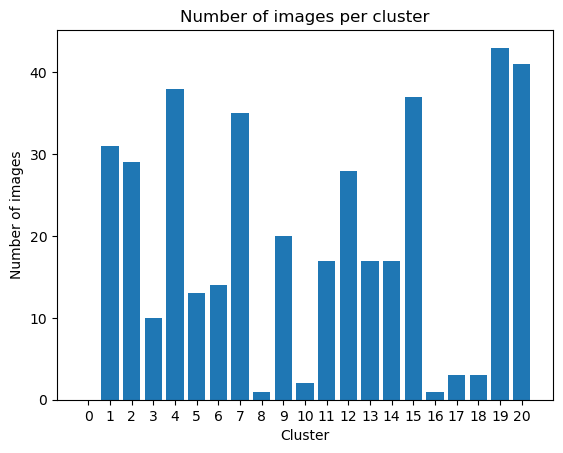

In [13]:
from collections import Counter

print(Counter(cluster_labels))

plt.bar(range(21), np.bincount(cluster_labels))
plt.xlabel('Cluster')
plt.ylabel('Number of images')
plt.title('Number of images per cluster')
plt.xticks(range(21))
plt.show()

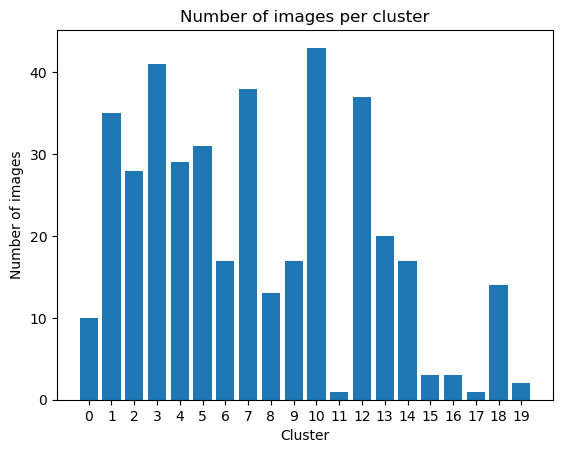

In [14]:
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=20, metric='cosine', linkage='average')
clustering.fit(X_train_rpca)
clustering.labels_

plt.bar(range(20), np.bincount(clustering.labels_))
plt.xlabel('Cluster')
plt.ylabel('Number of images')
plt.title('Number of images per cluster')
plt.xticks(range(20))
plt.show()